In [2]:
# Load Some Packages
import numpy as np
import imageio
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, ntpath
from tqdm import tqdm

In [3]:
import import_ipynb

In [4]:
from plot_3d import plotMatrix

importing Jupyter notebook from plot_3d.ipynb


In [5]:
# Given Some Coefficients in Partial(K)/Partial(t)
D = 0.75

# Given Some Coefficients in F(K)
A = -0.3
Kr = 0.03
Ktheta = 0.2
Km = 1.0

# Given Some Coefficients in Partial(r)/Partial(t)
B = 0.0001
C = 10.0

# max & min in colorbar
vmax = 1.0
vmin = 0.0

In [6]:
# Given the range of the rectangle
lenX = 50
lenY = 50
lenZ = 50

deltaX = 0.025 # cm
deltaY = 0.025 # cm
deltaZ = 0.025 # cm
# deltaT = (deltaX*deltaY*deltaZ)**2/(deltaX**2 + deltaY**2 + deltaZ**2)/2/D
deltaT = 0.000025 # sec
deltaT

2.5e-05

In [7]:
# Definie the filter of the laplacian operator
filter_laplacian = np.array([[[0, 0, 0],
                           [0, 1/deltaX**2, 0],
                           [0, 0, 0]],
                            [[0, 1/deltaZ**2, 0],
                           [1/deltaY**2, - 2/deltaX**2 - 2/deltaY**2 - 2/deltaZ**2, 1/deltaY**2],
                           [0, 1/deltaZ**2, 0]],
                            [[0, 0, 0],
                           [0, 1/deltaX**2, 0],
                           [0, 0, 0]]])

filter_laplacian

array([[[    0.,     0.,     0.],
        [    0.,  1600.,     0.],
        [    0.,     0.,     0.]],

       [[    0.,  1600.,     0.],
        [ 1600., -9600.,  1600.],
        [    0.,  1600.,     0.]],

       [[    0.,     0.,     0.],
        [    0.,  1600.,     0.],
        [    0.,     0.,     0.]]])

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [79]:
L = np.copy(K[20:30,20:30,20:30])
L[0,0,0] = 1
L[9,9,9]=0
L[2:8,2:8,2:8] = 0.9

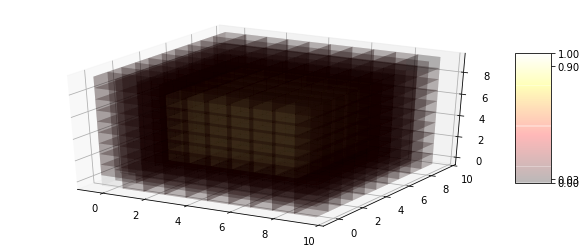

In [81]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_axes([0.1, 0.1, 0.7, 0.8], projection='3d')
ax_cb = fig.add_axes([0.8, 0.3, 0.05, 0.45])
plotMatrix(ax, range(10), range(10), range(10),L, cmap="hot", cax = ax_cb)

In [7]:
# A = np.arange(27).reshape((3,3,3))
A = np.ones((3,3,3))
A[2,2,2]= 0
A

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 0.]]])

In [ ]:
B = np.ones((2,2))
B

In [38]:
C = np.ones((50,50,50))

In [ ]:
A[:,:,0]

In [ ]:
sp.signal.convolve2d(A[:,:,0],B,mode = 'same', boundary='symm')

In [42]:
np.max(do_3d_time_step( C, filter_laplacian,boundary='Diri'))

0.0

In [8]:
def do_3d_time_step( target_array, filter_3d_laplacian, boundary):
    
    # target_array is l*m*n
    # filter_3d_laplacian is 3*3*3
    
    result_array = np.zeros(target_array.shape)
    
    # mode == 'same'

    if np.max(target_array) > np.min(target_array):
        for i in range(1,lenX-1):
            for j in range(1,lenY-1):
                for k in range(1,lenZ-1):
                    result_array[k,j,i] = np.sum(target_array[k-1:k+2,j-1:j+2,i-1:i+2]*filter_3d_laplacian) #np.sum(target_array[k-1:k+2,j-1:j+2,i-1:i+2]*filter_3d_laplacian)

#     if boundary == 'Diri' or boundary == 'Neum':
#         return result_array 
    
#     elif boundary == 'Perid':
        
        
    if boundary == 'Perid':
        
        temp_array = np.copy(target_array[-1,:,:])
        temp_array = np.vstack(temp_array,target_array[:2,:,:])
#         for i in range(lenX):
#             for j in range(lenY):
#                 result_array[0,j,i] = np.sum(target_array[]*filter_3d_laplacian)
    
    return result_array 

In [9]:
def Dirichlet_bd(maxIter, clamping_value, clamping_radius,
                 clamping_ticks, clamping_ticks_end,
                 foucs_loc,
                 K, Kt, R, Rt,
                 top, bottom, front, back, left, right):
    
    center_point_loc = int(lenX/2)
    center_point_loc = np.vstack((center_point_loc, int(lenY/2)))
    center_point_loc = np.vstack((center_point_loc, int(lenZ/2)))
    point_value = np.zeros([maxIter, foucs_loc.shape[0]])
    R_value = np.zeros([maxIter, foucs_loc.shape[0]])
    
#     # Fixed the boundary values
#     K[0,:,:] = left
#     K[-1,:,:] = right
#     K[:,0,:] = front
#     K[:,-1,:] = back
#     K[:,:,0] = top
#     K[:,:,-1] = bottom
    
    for i in tqdm(range(maxIter)):
        
        if i >= clamping_ticks and i <= clamping_ticks_end:  
            r2 = clamping_radius**2
            for a in range(lenX):
                for b in range(lenY):
                    for c in range(lenZ):
                        dis2 = (a-center_point_loc[0])**2 + (b-center_point_loc[1])**2 + (c-center_point_loc[1])**2
                        if dis2 < r2:
                            K[a,b,c] = clamping_value

        # Fick's second law
#         R = R + deltaT*Rt
#         Kt = D*sp.signal.convolve3d(K, filter_laplacian, mode = 'same', boundary='symm') + A*(K - Kr)*(K - Ktheta)*(K - Km)*(K + 0.1) - R*K
#         K = K + deltaT*Kt


        R = R + deltaT*Rt
    
#         Kt = sp.signal.convolve3d(K, filter_laplacian, mode = 'same', boundary='symm')

#         print(np.max(K), np.min(K), np.max(Kt), np.min(Kt))
        Kt = do_3d_time_step( target_array=K, filter_3d_laplacian=filter_laplacian, boundary='Diri')
        Kt = D*Kt + A*(K - Kr)*(K - Ktheta)*(K - Km)*(K + 0.1) - R*K
        K = K + deltaT*Kt

    
    
        # Fixed the boundary values
        K[0,:,:] = left
        K[-1,:,:] = right
        K[:,0,:] = front
        K[:,-1,:] = back
        K[:,:,0] = top
        K[:,:,-1] = bottom

        # plot the images
#         fig, ax = plt.subplots()
        
#         fig = plt.figure(figsize=(10,4))
#         ax = fig.add_axes([0.1, 0.1, 0.7, 0.8], projection='3d')
#         ax_cb = fig.add_axes([0.8, 0.3, 0.05, 0.45])
#         im = plotMatrix(ax, np.array(range(lenX)), np.array(range(lenY)), np.array(range(lenZ)), K, cmap="hot", cax = ax_cb)
        
# #         im = ax.imshow(K, cmap='hot', vmin=vmin,vmax=vmax)
# #         ax.set_axis_off()
#         ax.set_title('{:.1f} ms'.format(i*deltaT*1000))
# #         fig.colorbar(im, cax=fig.add_axes(), orientation='vertical')
#         plt.savefig('./images/3D_Diri/{}.png'.format(i))
#         plt.clf()
        
        # Fick's second law
        Rt = B*((K-Kr) - C*R)
        
#         print(np.max(K), np.min(K), np.max(Kt), np.min(Kt))
        
        for j in range(foucs_loc.shape[0]):
            point_value[i,j] = K[foucs_loc[j,0],foucs_loc[j,1],foucs_loc[j,2]]
            R_value[i,1] = R[foucs_loc[j,0],foucs_loc[j,1],foucs_loc[j,2]]
        
    return point_value, R_value

In [10]:
def Neumann_bd(maxIter, clamping_value, clamping_radius,
                 clamping_ticks, clamping_ticks_end,
                 foucs_loc,
                 K, Kt, R, Rt,
                 top, bottom, front, back, left, right):
    
    center_point_loc = int(lenX/2)
    center_point_loc = np.vstack((center_point_loc, int(lenY/2)))
    center_point_loc = np.vstack((center_point_loc, int(lenZ/2)))
    point_value = np.zeros([maxIter, foucs_loc.shape[0]])
    R_value = np.zeros([maxIter, foucs_loc.shape[0]])
    
    
    for i in tqdm(range(maxIter)):

        if i >= clamping_ticks and i <= clamping_ticks_end:  
            r2 = clamping_radius**2
            for a in range(lenX):
                for b in range(lenY):
                    for c in range(lenZ):
                        dis2 = (a-center_point_loc[0])**2 + (b-center_point_loc[1])**2 + (c-center_point_loc[1])**2
                        if dis2 < r2:
                            K[a,b,c] = clamping_value
        
        # Fick's second law
#         R = R + deltaT*Rt

#         Kt = sp.signal.convolve3d(K, filter_laplacian, mode = 'same')
#         Kt = D*Kt + A*(K - Kr)*(K - Ktheta)*(K - Km)*(K + 0.1) - R*K
#         K = K + deltaT*Kt
        
        R = R + deltaT*Rt

#         Kt = sp.signal.convolve3d(K, filter_laplacian, mode = 'same')
        Kt = do_3d_time_step( target_array=K, filter_3d_laplacian=filter_laplacian, boundary='Diri')
        
        Kt = D*Kt + A*(K - Kr)*(K - Ktheta)*(K - Km)*(K + 0.1) - R*K
        
        # Fixed the differential boundary values
        Kt[0,:,:] = left
        Kt[-1,:,:] = right
        Kt[:,0,:] = front
        Kt[:,-1,:] = back
        Kt[:,:,0] = top
        Kt[:,:,-1] = bottom
        
        K = K + deltaT*Kt
        
        
        # Fixed the differential boundary values
#         Kt[0,:,:] = left
#         Kt[-1,:,:] = right
#         Kt[:,0,:] = front
#         Kt[:,-1,:] = back
#         Kt[:,:,0] = top
#         Kt[:,:,-1] = bottom
        
        
        # plot the images
        fig = plt.figure(figsize=(10,4))
        im = ax.imshow(K, cmap='hot', vmin=vmin,vmax=vmax)
        ax.set_axis_off()
        ax.set_title('{:.1f} ms'.format(i*deltaT*1000))
        fig.colorbar(im, cax=fig.add_axes(), orientation='vertical')
        plt.savefig('./images/Neum/{}.png'.format(i))
        plt.clf()

        # Fick's second law
        Rt = B*((K-Kr) - C*R)

        for j in range(foucs_loc.shape[0]):
            point_value[i,j] = K[foucs_loc[j,0],foucs_loc[j,1],foucs_loc[j,2]]
            R_value[i,1] = R[foucs_loc[j,0],foucs_loc[j,1],foucs_loc[j,2]]
        
    return point_value, R_value

In [11]:
def Periodic_bd(maxIter, clamping_value, clamping_radius,
                 clamping_ticks, clamping_ticks_end,
                 foucs_loc,
                 K, Kt, R, Rt,
                 top, bottom, front, back, left, right):
    
    center_point_loc = int(lenX/2)
    center_point_loc = np.vstack((center_point_loc, int(lenY/2)))
    center_point_loc = np.vstack((center_point_loc, int(lenZ/2)))
    point_value = np.zeros([maxIter, foucs_loc.shape[0]])
    R_value = np.zeros([maxIter, foucs_loc.shape[0]])
    
    
    for i in tqdm(range(maxIter)):

        if i >= clamping_ticks and i <= clamping_ticks_end:  
            r2 = clamping_radius**2
            for a in range(lenX):
                for b in range(lenY):
                    for c in range(lenZ):
                        dis2 = (a-center_point_loc[0])**2 + (b-center_point_loc[1])**2 + (c-center_point_loc[1])**2
                        if dis2 < r2:
                            K[a,b,c] = clamping_value
        
        # Fick's second law
        R = R + deltaT*Rt
        Kt = D*sp.signal.convolve3d(K, filter_laplacian, mode = 'same', boundary = 'wrap') + A*(K - Kr)*(K - Ktheta)*(K - Km)*(K + 0.1) - R*K
        K = K + deltaT*Kt
        
        # plot the images
        fig, ax = plt.subplots()
        im = ax.imshow(K, cmap='hot', vmin=vmin,vmax=vmax)
        ax.set_axis_off()
        ax.set_title('{:.1f} ms'.format(i*deltaT*1000))
        fig.colorbar(im, cax=fig.add_axes(), orientation='vertical')
        plt.savefig('../images/Perid/{}.png'.format(i))
        plt.clf()
        # Fick's second law
        Rt = B*((K-Kr) - C*R)

        for j in range(foucs_loc.shape[0]):
            point_value[i,j] = K[foucs_loc[j,0],foucs_loc[j,1],foucs_loc[j,2]]
            R_value[i,1] = R[foucs_loc[j,0],foucs_loc[j,1],foucs_loc[j,2]]
        
    return center_point_value, R_value

In [12]:
def compute_fick_law(boundary, maxIter,
                     clamping_value, clamping_radius, clamping_ticks, clamping_ticks_end, 
                     foucs_loc, K, Kt, R, Rt, 
                     top=0.0, bottom=0.0, front=0.0, back=0.0, left=0.0, right=0.0):
    '''N: The number of the random points you want to pick'''
    '''clamping_ticks: '''
    
    # remove other images in the dir
    for image in sorted(glob.glob('./images/*.png'), key=lambda k: int(ntpath.basename(k).replace('.png', ''))):
        os.remove(image)
    
    if boundary == 'Diri':
        point_value, R_value = Dirichlet_bd(maxIter,
                                            clamping_value, clamping_radius, clamping_ticks, clamping_ticks_end,
                                            foucs_loc, K, Kt, R, Rt, 
                                            top, bottom, front, back, left, right)
        
    elif boundary == 'Neum':
        point_value, R_value = Neumann_bd(maxIter, 
                                          clamping_value, clamping_radius, clamping_ticks, clamping_ticks_end, 
                                          foucs_loc, K, Kt, R, Rt, 
                                          top, bottom, front, back, left, right)
        
    elif boundary == 'Perid':
        point_value, R_value = Periodic_bd(maxIter, 
                                           clamping_value, clamping_radius, clamping_ticks, clamping_ticks_end, 
                                           foucs_loc, K, Kt, R, Rt)
            
    return point_value, R_value

In [13]:
def make_video(images, image_folder, video_name, outimg=None, fps=5, size=None,
               is_color=True, format="XVID"):
    
    from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
    fourcc = VideoWriter_fourcc(*format)
    vid = None
    for image in images:
        if not os.path.join(image_folder, image):
            raise FileNotFoundError(image)
        img = imread(os.path.join(image_folder, image))
        if vid is None:
            if size is None:
                size = img.shape[1], img.shape[0]
            vid = VideoWriter(video_name, fourcc, float(fps), size, is_color)
        if size[0] != img.shape[1] and size[1] != img.shape[0]:
            img = resize(img, size)
        vid.write(img)
    vid.release()
    return vid

In [14]:
# Given Initial values
maxIter = 500
K = np.full([lenX, lenY, lenZ], Kr, dtype=np.float64)
Kt = np.zeros([lenX, lenY, lenZ], dtype=np.float64)
R = np.zeros([lenX, lenY, lenZ], dtype=np.float64)
Rt = np.zeros([lenX, lenY, lenZ], dtype=np.float64)

In [15]:
center_point_loc = np.array([int(lenX/2),int(lenY/2),int(lenZ/2)])

In [22]:
maxIter = 1000
clamping_value=np.arange(0,1.1,0.1)
clamping_value[0]=0.05
clamping_radius=np.arange(1,5.5,0.5)
clamping_ticks=20
clamping_ticks_end=100

foucs_loc=np.array([[int(lenX/2),int(lenY/2),int(lenZ/2)],
                     [int(lenX/2)+3,int(lenY/2)+3,int(lenZ/2)+3]])

In [17]:
clamping_value

array([0.05, 0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 1.  ])

In [18]:
clamping_radius.shape

(9,)

In [106]:
initial = True
for i in range(clamping_radius.shape[0]):
    for j in range(clamping_value.shape[0]):

        foucs_loc=np.array([[int(lenX/2),int(lenY/2),int(lenZ/2)],
                            [int(lenX/2+clamping_radius[i]),int(lenY/2+clamping_radius[i]),int(lenZ/2+clamping_radius[i])],
                           [int(lenX/2+clamping_radius[i]+10),int(lenY/2+clamping_radius[i]+10),int(lenZ/2+clamping_radius[i]+10)]])
        
        point_value, R_value = compute_fick_law('Diri', maxIter,
                             clamping_value[j], clamping_radius[i], clamping_ticks, clamping_ticks_end,
                             foucs_loc, K, Kt, R, Rt, 
                             Kr, Kr, Kr, Kr, Kr, Kr)
        
        result_point_value = point_value if initial else np.vstack((result_point_value,point_value))
        result_R_value = R_value if initial else np.vstack((result_R_value,R_value))
        
        initial = False


100%|██████████| 1000/1000 [15:34<00:00,  1.06it/s]


In [109]:
np.argmax(result_point_value[:1000,1:], axis=0)

array([107, 999])

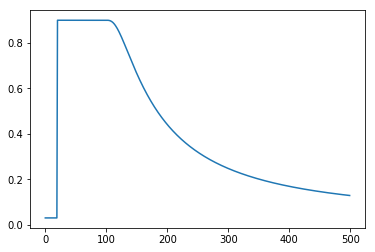

In [68]:
plt.plot(point_value[:,0])

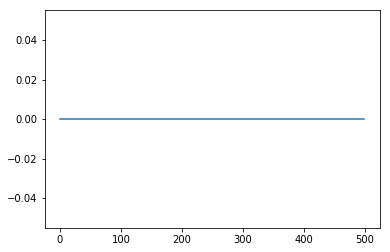

In [69]:
plt.plot(R_value[:,0])

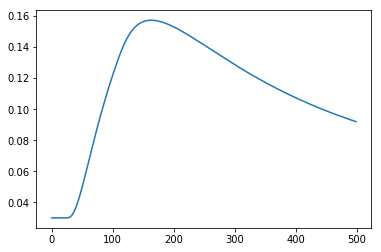

In [70]:
plt.plot(point_value[:,1])

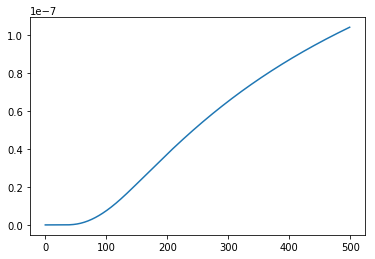

In [71]:
plt.plot(R_value[:,1])

In [36]:
def Dirichlet_bd_make_3D_fig(maxIter, clamping_value, clamping_radius,
                 clamping_ticks, clamping_ticks_end,
                 foucs_loc,
                 K, Kt, R, Rt,
                 top, bottom, front, back, left, right):
    
    record_K = np.empty((maxIter, K.shape[0], K.shape[1], K.shape[2]))
    
    center_point_loc = int(lenX/2)
    center_point_loc = np.vstack((center_point_loc, int(lenY/2)))
    center_point_loc = np.vstack((center_point_loc, int(lenZ/2)))
    point_value = np.zeros([maxIter, foucs_loc.shape[0]])
    R_value = np.zeros([maxIter, foucs_loc.shape[0]])
    
#     # Fixed the boundary values
#     K[0,:,:] = left
#     K[-1,:,:] = right
#     K[:,0,:] = front
#     K[:,-1,:] = back
#     K[:,:,0] = top
#     K[:,:,-1] = bottom
    
    for i in tqdm(range(maxIter)):
        
        if i >= clamping_ticks and i <= clamping_ticks_end:  
            r2 = clamping_radius**2
            for a in range(lenX):
                for b in range(lenY):
                    for c in range(lenZ):
                        dis2 = (a-center_point_loc[0])**2 + (b-center_point_loc[1])**2 + (c-center_point_loc[1])**2
                        if dis2 < r2:
#                         if dis2 < 25 and dis2 >r2:
                            K[a,b,c] = clamping_value

        # Fick's second law
        R = R + deltaT*Rt
        Kt = do_3d_time_step( target_array=K, filter_3d_laplacian=filter_laplacian, boundary='Diri')
        Kt = D*Kt + A*(K - Kr)*(K - Ktheta)*(K - Km)*(K + 0.1) - R*K
        K = K + deltaT*Kt

    
    
        # Fixed the boundary values
        K[0,:,:] = left
        K[-1,:,:] = right
        K[:,0,:] = front
        K[:,-1,:] = back
        K[:,:,0] = top
        K[:,:,-1] = bottom

        
        # Fick's second law
        Rt = B*((K-Kr) - C*R)
        
        record_K[i,...] = np.copy(K)
        
#         for j in range(foucs_loc.shape[0]):
#             point_value[i,j] = K[foucs_loc[j,0],foucs_loc[j,1],foucs_loc[j,2]]
#             R_value[i,1] = R[foucs_loc[j,0],foucs_loc[j,1],foucs_loc[j,2]]
        
#     return point_value, R_value
    
    return record_K

In [20]:
Kr

0.03

In [38]:
record_K = Dirichlet_bd_make_3D_fig(500, 1.0, 3,
                 50, 200,
                 foucs_loc,
                 K, Kt, R, Rt,
                 Kr, Kr, Kr, Kr, Kr, Kr)


100%|██████████| 500/500 [10:00<00:00,  1.12it/s]


In [ ]:
plt.imshow(record_K_donuts[], cmap='hot', vmin=0,vmax=1)

In [39]:
record_K.shape

(500, 50, 50, 50)

In [120]:
X = np.arange(0, 1.25, 0.025)
Y = np.arange(0, 1.25, 0.025)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)

In [121]:
R.shape

(50, 50)

In [187]:
Z = record_K[200,:,:,24]

In [24]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [27]:
record_K_donuts.shape

(500, 50, 50, 50)

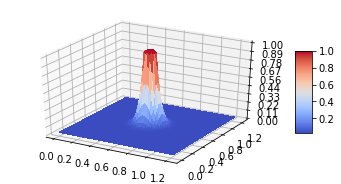

In [194]:
fig = plt.figure(figsize=(6,3))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, 1)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# plt.xlabel('concentration')
# ax.zaxis.label('concentration')
# ax.yaxis.label('')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

In [148]:
see_line_concentration_time = record_K[:,:,24,24]
see_line_concentration_time.shape

(1000, 50)

In [ ]:
record_K[200,:,:,24].shape

In [46]:
G = np.array([[[0,0.2,0.4,0.6,0.8,1.0],
             [0,0.2,0.4,0.6,0.8,1.0]],
              [[0,0.2,0.4,0.6,0.8,1.0],
             [0,0.2,0.4,0.6,0.8,1.0]]])

In [47]:
G.shape

(2, 2, 6)

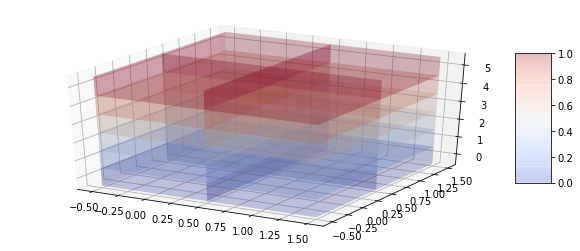

In [48]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_axes([0.1, 0.1, 0.7, 0.8], projection='3d')
ax_cb = fig.add_axes([0.8, 0.3, 0.05, 0.45])
plotMatrix(ax, range(2), range(2), range(6),G, cmap=cm.coolwarm, cax = ax_cb)

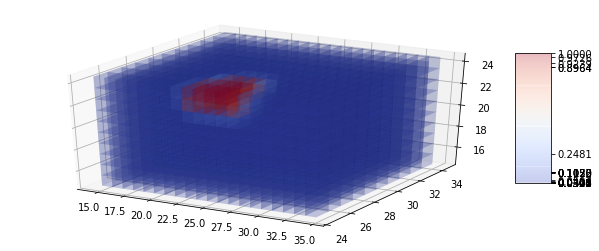

In [43]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_axes([0.1, 0.1, 0.7, 0.8], projection='3d')
ax_cb = fig.add_axes([0.8, 0.3, 0.05, 0.45])
plotMatrix(ax, range(15, 35), range(25, 35), range(15, 25),record_K[52,15:35,25:35,15:25], cmap=cm.coolwarm, cax = ax_cb)

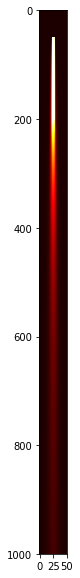

In [176]:
plt.figure(figsize=(100,10))
plt.imshow(see_line_concentration_time, cmap='hot', vmin=0,vmax=1)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 100
plt.rcParams["figure.figsize"] = fig_size